# Benchmark Matrix 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
import adelie as ad
import bench_matrix as bm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy

## Utility Functions

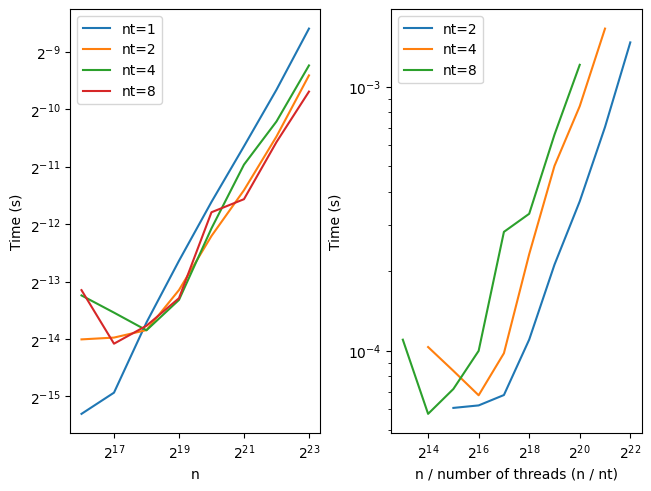

In [51]:
_ = bm.bench_dvaddi(
    n_list=2 ** np.arange(16, 24),
    n_sims=100,
)

## MatrixNaive

In [2]:
def bench_naive(X, q=8, L=10):
    n, p = X.rows(), X.cols()
    df = pd.DataFrame()

    weights = np.ones(n)
    sqrt_weights = np.sqrt(weights)

    v = np.random.normal(0, 1, n)
    start = time()
    X.cmul(0, v, weights)
    elapsed = time() - start
    df["cmul"] = [elapsed * 1e3]

    v = 1.3
    out = np.empty(n)
    start = time()
    X.ctmul(0, v, out)
    elapsed = time() - start
    df["ctmul"] = [elapsed * 1e3]

    v = np.random.normal(0, 1, n)
    out = np.empty(q)
    start = time()
    X.bmul(0, q, v, weights, out)
    elapsed = time() - start
    df["bmul"] = [elapsed * 1e3]

    v = np.random.normal(0, 1, q)
    out = np.empty(n)
    start = time()
    X.btmul(0, q, v, out)
    elapsed = time() - start
    df["btmul"] = [elapsed * 1e3]

    v = np.random.normal(0, 1, n)
    out = np.empty(p)
    start = time()
    X.mul(v, weights, out)
    elapsed = time() - start
    df["mul"] = [elapsed * 1e3]

    v = np.random.normal(0, 1, n)
    out = np.empty((q, q), order="F")
    buffer = np.empty((n, q), order="F")
    start = time()
    X.cov(0, q, sqrt_weights, out, buffer)
    elapsed = time() - start
    df["cov"] = [elapsed * 1e3]

    v = np.random.normal(0, 1, (L, p))
    v.ravel()[np.random.binomial(1, 0.5, v.size)] = 0
    v = scipy.sparse.csr_matrix(v)
    out = np.empty((L, n))
    start = time()
    X.sp_btmul(v, out)
    elapsed = time() - start
    df["sp_btmul"] = [elapsed * 1e3]

    return df

## ad.matrix.dense

In [17]:
n = 1000
p = 1000
q = 512
X = np.asfortranarray(np.random.normal(0, 1, (n, p)))

In [31]:
bench_naive(ad.matrix.dense(X, method="naive", n_threads=1), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.013113,0.003815,0.144958,0.08893,0.226021,10.204077,0.778913


In [35]:
bench_naive(ad.matrix.dense(X, method="naive", n_threads=4), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.014067,0.004768,0.154018,0.092983,0.133276,11.543036,0.776052


## ad.matrix.kronecker_eye

In [44]:
n = 1000
p = 100
K = 8
X = np.asfortranarray(np.random.normal(0, 1, (n, p)))

In [45]:
bench_naive(ad.matrix.kronecker_eye(X, K=K, n_threads=1), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.010967,0.005007,0.00906,0.010967,0.138044,0.02408,2.131939


In [46]:
bench_naive(ad.matrix.kronecker_eye(X, K=K, n_threads=4), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.013828,0.007153,0.011921,0.010967,0.234842,0.023842,1.406908


In [47]:
bench_naive(ad.matrix.kronecker_eye(ad.matrix.dense(X, n_threads=1), K=K, n_threads=1), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.013828,0.005245,0.026703,0.016212,0.138044,0.010967,1.92523


In [48]:
bench_naive(ad.matrix.kronecker_eye(ad.matrix.dense(X, n_threads=4), K=K, n_threads=4), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.020981,0.009775,0.036001,0.02408,0.338316,0.018835,1.791


## ad.matrix.snp_unphased

In [3]:
n = 10000
p = 100
seed = 0
data = ad.data.hased(n, p, seed=seed)
filename = "/tmp/bench_snp_unphased.snpdat"
handler = ad.io.snp_unphased(filename)
_ = handler.write(data["X"])

In [4]:
bench_naive(ad.matrix.snp_unphased(filename, n_threads=1))

,cmul,ctmul,bmul,btmul,mul,cov
0,0.013113,0.008821,0.044823,0.061035,0.308275,0.766039


In [5]:
bench_naive(ad.matrix.snp_unphased(filename, n_threads=4))

,cmul,ctmul,bmul,btmul,mul,cov
0,0.011921,0.029802,0.119925,0.036955,0.127077,0.39196


In [20]:
os.remove(filename)

## ad.matrix.snp_phased_ancestry

In [3]:
n = 100000
s = 100
A = 8
seed = 0
data = ad.data.snp_phased_ancestry(n, s, A, seed=seed)
filename = "/tmp/bench_snp_phased_ancestry.snpdat"
handler = ad.io.snp_phased_ancestry(filename)
_ = handler.write(data["X"], data["ancestries"], A)

In [7]:
bench_naive(ad.matrix.snp_phased_ancestry(filename, n_threads=1))

,cmul,ctmul,bmul,btmul,mul,cov
0,0.07987,0.109196,0.08297,0.081301,5.756855,0.431299


In [10]:
bench_naive(ad.matrix.snp_phased_ancestry(filename, n_threads=8))

,cmul,ctmul,bmul,btmul,mul,cov
0,0.051022,0.069141,0.09203,0.054121,1.181841,0.426054


In [ ]:
os.remove(filename)